In [1]:
import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from edward.models import Normal, Empirical

/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: 

In [2]:
tf.app.flags.DEFINE_string('f', '', 'kernel')
tf.flags.DEFINE_integer("N", default=40, help="Number of data points.")
tf.flags.DEFINE_integer("D", default=1, help="Number of features.")
tf.flags.DEFINE_integer("T", default=5000, help="Number of posterior samples.")
tf.flags.DEFINE_integer("nburn", default=100,
                        help="Number of burn-in samples.")
tf.flags.DEFINE_integer("stride", default=10,
                        help="Frequency with which to plots samples.")

FLAGS = tf.flags.FLAGS

In [3]:
def build_toy_dataset(N, noise_std=0.5):
  X = np.concatenate([np.linspace(0, 2, num=int(N / 2.0)),
                      np.linspace(6, 8, num=int(N / 2.0))])
  y = 2.0 * X + 10 * np.random.normal(0, noise_std, size=N)
  X = X.reshape((N, 1))
  return X, y

In [4]:
 ed.set_seed(42)

In [5]:
# DATA
X_train, y_train = build_toy_dataset(FLAGS.N)
X_test, y_test = build_toy_dataset(FLAGS.N)
print(X_train, y_train)

[[0.        ]
 [0.10526316]
 [0.21052632]
 [0.31578947]
 [0.42105263]
 [0.52631579]
 [0.63157895]
 [0.73684211]
 [0.84210526]
 [0.94736842]
 [1.05263158]
 [1.15789474]
 [1.26315789]
 [1.36842105]
 [1.47368421]
 [1.57894737]
 [1.68421053]
 [1.78947368]
 [1.89473684]
 [2.        ]
 [6.        ]
 [6.10526316]
 [6.21052632]
 [6.31578947]
 [6.42105263]
 [6.52631579]
 [6.63157895]
 [6.73684211]
 [6.84210526]
 [6.94736842]
 [7.05263158]
 [7.15789474]
 [7.26315789]
 [7.36842105]
 [7.47368421]
 [7.57894737]
 [7.68421053]
 [7.78947368]
 [7.89473684]
 [8.        ]] [ 2.48357077e+00 -4.80795190e-01  3.65949532e+00  8.24672823e+00
 -3.28661610e-01 -1.18053206e-01  9.15922197e+00  5.31085786e+00
 -6.63161403e-01  4.60753706e+00 -2.11825306e-01 -1.28592942e-02
  3.73612715e+00 -6.82955912e+00 -5.67722074e+00  3.46457091e-01
 -1.69573455e+00  5.15018403e+00 -7.50646693e-01 -3.06151851e+00
  1.93282438e+01  1.10816448e+01  1.27586937e+01  5.50783802e+00
  1.01201916e+01  1.36072445e+01  7.50819001e+00 

In [6]:
# MODEL
X = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(FLAGS.N))

In [7]:
# INFERENCE
qw = Empirical(params=tf.get_variable("qw/params", [FLAGS.T, FLAGS.D]))
qb = Empirical(params=tf.get_variable("qb/params", [FLAGS.T, 1]))

inference = ed.SGHMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(step_size=1e-3)

/home/jovyan/.local/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


5000/5000 [100%] ██████████████████████████████ Elapsed: 15s | Acceptance Rate: 1.000


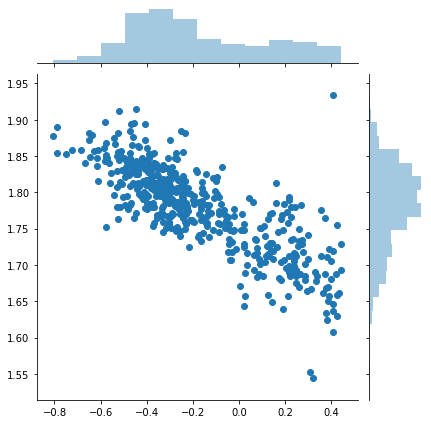

In [8]:
# CRITICISM

# Plot posterior samples.
sns.jointplot(qb.params.eval()[FLAGS.nburn:FLAGS.T:FLAGS.stride],
            qw.params.eval()[FLAGS.nburn:FLAGS.T:FLAGS.stride])
plt.show()

Mean squared error on test data:
24.10617
Displaying prior predictive samples.


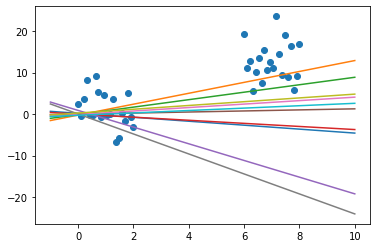

In [11]:
# Posterior predictive checks.
y_post = ed.copy(y, {w: qw, b: qb})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(FLAGS.N))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Displaying prior predictive samples.")
n_prior_samples = 10

w_prior = w.sample(n_prior_samples).eval()
b_prior = b.sample(n_prior_samples).eval()

plt.scatter(X_train, y_train)

inputs = np.linspace(-1, 10, num=400)
for ns in range(n_prior_samples):
  output = inputs * w_prior[ns] + b_prior[ns]
  plt.plot(inputs, output)

plt.show()

Displaying posterior predictive samples.


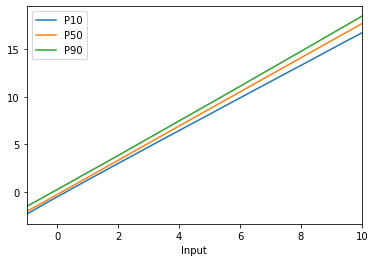

In [10]:
import pandas as pd
print("Displaying posterior predictive samples.")
n_posterior_samples = 1000

w_post = qw.sample(n_posterior_samples).eval()
b_post = qb.sample(n_posterior_samples).eval()

#plt.scatter(X_train, y_train)

inputs = np.linspace(-1, 10, num=400)
df = pd.DataFrame()
for ns in range(n_posterior_samples):
  output = inputs * w_post[ns] + b_post[ns]
  df.loc[:, ns] = output
  #plt.plot(inputs, output)

df['P50'] = df.quantile(q=0.5, axis=1, numeric_only=True, interpolation='linear')
df['P10'] = df.quantile(q=0.1, axis=1, numeric_only=True, interpolation='linear')
df['P90'] = df.quantile(q=0.9, axis=1, numeric_only=True, interpolation='linear')
df['Input'] = inputs

df.plot(x='Input', y=['P10','P50','P90'])

plt.show()